<a href="https://colab.research.google.com/github/spetti/SMURF/blob/main/examples/af_msa_backprop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%bash
if [ ! -d af_backprop ]; then
  git clone https://github.com/sokrypton/af_backprop.git
  pip -q install py3Dmol biopython ml_collections dm-haiku
fi
if [ ! -d SMURF ]; then
  git clone https://github.com/spetti/SMURF.git
fi
if [ ! -d params ]; then
  mkdir params
  curl -fsSL https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar | tar x -C params
fi

Cloning into 'af_backprop'...
Cloning into 'SMURF'...


You should consider upgrading via the '/n/home01/spetti/.conda/envs/alphafold_new/bin/python -m pip install --upgrade pip' command.
tar: .: implausibly old time stamp 1969-12-31 19:00:00


In [2]:
! nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Tue_Sep_15_19:10:02_PDT_2020
Cuda compilation tools, release 11.1, V11.1.74
Build cuda_11.1.TC455_06.29069683_0


In [1]:
import os
import jax
import jax.numpy as jnp
from jax.example_libraries.optimizers import adam
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('af_backprop')
sys.path.append('SMURF')
from utils import *

import laxy
import sw_functions as sw
import network_functions as nf

# import libraries
from alphafold.common import protein
from alphafold.data import pipeline
from alphafold.model import data, config, model
from alphafold.data import parsers
from alphafold.model import all_atom

/n/home01/spetti/.conda/envs/alphafold_new/lib/python3.7/site-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)


In [2]:
#os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/n/helmod/apps/centos7/Core/cuda/11.1.0-fasrc01"
#os.environ["TF_CPP_MIN_LOG_LEVEL"]= "0"

In [3]:
! nvidia-smi

Fri Mar 18 12:41:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:1A:00.0 Off |                    0 |
| N/A   41C    P0    43W / 300W |      3MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
def get_feat(filename, alphabet="ARNDCQEGHILKMFPSTWYV"):
  '''
  Given A3M file (from hhblits)
  return MSA (aligned), MS (unaligned) and ALN (alignment)
  '''
  def parse_fasta(filename):
    '''function to parse fasta file'''    
    header, sequence = [],[]
    lines = open(filename, "r")
    for line in lines:
      line = line.rstrip()
      if len(line) == 0: pass
      else:
        if line[0] == ">":
          header.append(line[1:])
          sequence.append([])
        else:
          sequence[-1].append(line)
    lines.close()
    sequence = [''.join(seq) for seq in sequence]
    return header, sequence

  names, seqs = parse_fasta(filename)  
  a2n = {a:n for n,a in enumerate(alphabet)}
  def get_seqref(x):
    n,seq,ref,aligned_seq = 0,[],[],[]
    for aa in list(x):
      if aa != "-":
        seq.append(a2n.get(aa.upper(),-1))
        if aa.islower(): ref.append(-1); n -= 1
        else: ref.append(n); aligned_seq.append(seq[-1])
      else: aligned_seq.append(-1)
      n += 1
    return seq, ref, aligned_seq
  
  # get the multiple sequence alignment
  max_len = 0
  ms, aln, msa = [],[],[]
  for seq in seqs:
    seq_,ref_,aligned_seq_ = get_seqref(seq)
    if len(seq_) > max_len: max_len = len(seq_)
    ms.append(seq_)
    msa.append(aligned_seq_)
    aln.append(ref_)
  
  return msa, ms, aln

In [5]:
def prep_inputs(DOM, restrict_to = None):
  a3m_file = f"SMURF/examples/CASP_examples/{DOM}.mmseqs.id90cov75.a3m"
  _, ms, aln = get_feat(a3m_file)
  if restrict_to is not None:
    ms = [ms[_] for _ in restrict_to]
    aln = [aln[_] for _ in restrict_to]
  lens = np.asarray([len(m) for m in ms])
  ms = nf.one_hot(nf.pad_max(ms))
  aln = nf.one_hot(nf.pad_max(aln))
  N = len(ms)
  protein_obj = protein.from_pdb_string(pdb_to_string(f"SMURF/examples/CASP_examples/{DOM}.pdb"))
  batch = {'aatype': protein_obj.aatype,
          'all_atom_positions': protein_obj.atom_positions,
          'all_atom_mask': protein_obj.atom_mask}
  batch.update(all_atom.atom37_to_frames(**batch)) # for fape calculcation
  msa, mtx = parsers.parse_a3m(open(a3m_file,"r").read())
  if restrict_to is not None:
    msa = [msa[_] for _ in restrict_to]
    mtx = [mtx[_] for _ in restrict_to]
  feature_dict = {
      **pipeline.make_sequence_features(sequence=msa[0],description="none",num_res=len(msa[0])),
      **pipeline.make_msa_features(msas=[msa], deletion_matrices=[mtx])
  }
  feature_dict["residue_index"] = protein_obj.residue_index
  return {"N":N,"lens":lens,
          "ms":ms,"aln":aln,
          "feature_dict":feature_dict,
          "protein_obj":protein_obj, "batch":batch}

In [6]:
def get_model_runner(num_seq, model_name="model_3_ptm", dropout=False, backprop_recycles=False, is_training = False, mask = False):
  # setup which model params to use
  model_config = config.model_config(model_name)
  model_config.model.global_config.use_remat = True

  model_config.model.num_recycle = 3
  model_config.data.common.num_recycle = 3

  model_config.data.eval.max_msa_clusters = num_seq
  model_config.data.common.max_extra_msa = 1
  if not mask:
    model_config.data.eval.masked_msa_replace_fraction = 0

  # backprop through recycles
  model_config.model.backprop_recycle = backprop_recycles
  model_config.model.embeddings_and_evoformer.backprop_dgram = backprop_recycles

  if not dropout:
    model_config = set_dropout(model_config,0)

  # setup model
  model_params = data.get_model_haiku_params(model_name=model_name, data_dir=".")
  model_runner = model.RunModel(model_config, model_params, is_training=is_training)
  return model_runner, model_params

In [7]:
class model_d():
    def __init__(self, dropout = False, backprop_recycles = False, mask = False):
        self.dropout = False
        self.backprop_recycles = False
        self.models = {}
        self.mask = mask
    def make_model_w_input_size(self,n):
        if n not in self.models.keys():
            self.models[n] = get_model_runner(n, dropout=self.dropout, backprop_recycles=self.backprop_recycles, mask= self.mask)

In [8]:
def drop_and_run_af(model_d, DOM, restrict_to = None, mod_msa = None, seed = 0):
    key = jax.random.PRNGKey(seed)
    INPUTS = prep_inputs(DOM, restrict_to = restrict_to)
    model_d.make_model_w_input_size(INPUTS["N"])
    model_runner, model_params = model_d.models[INPUTS["N"]]
    af_inputs = model_runner.process_features(INPUTS["feature_dict"], random_seed=seed)
    if mod_msa is not None:
        if restrict_to is not None:
            mod_msa = mod_msa[restrict_to,...]
        af_inputs["msa_feat"] = jnp.zeros_like(af_inputs["msa_feat"]).at[...,0:22].set(mod_msa).at[...,25:47].set(mod_msa)
    af_outputs = model_runner.apply(model_params, key, af_inputs)
    return af_inputs, af_outputs

In [9]:
def rmsd(INPUTS, outputs):
    return jnp_rmsd(INPUTS["protein_obj"].atom_positions[:,1,:],
                         outputs["structure_module"]["final_atom_positions"][:,1,:]).item()

def mean_plddt(outputs):
    return jnp.mean(get_plddt(outputs)).item()

In [10]:
def plot_plddt_per_pos( output):
    ps = get_plddt(output)
    plt.scatter(range(ps.shape[0]), ps)
    plt.xlabel("position")
    plt.ylabel("plddt")

In [11]:
def drop_each_seq(model_d, DOM, mod_msa=None):
    rmsds = []
    plddts = []
    mean_plddts = []
    outputs = []
    INPUTS = prep_inputs(DOM) # just to get num seq and structure
    for i in range(1,INPUTS["N"]):
        print(f"removing seq {i}")
        restrict_to = [_ for _ in range(INPUTS["N"]) if _!= i]
        _, output = drop_and_run_af(model_d, DOM, restrict_to = restrict_to, mod_msa = mod_msa, seed = 0)
        rmsds.append(rmsd(INPUTS, output))
        mean_plddts.append(mean_plddt(output))
        plddts.append(get_plddt(output))
        outputs.append(output)
    dout = {}
    dout["rmsds"] = rmsds
    dout["plddts"] = plddts
    dout["mean_plddts"] = mean_plddts
    dout["outputs"] = outputs
    return dout

In [12]:
def restrict_and_print_error(md, DOM,  restrict_to_combos, mod_msa= None):
    if mod_msa is not None:
        print("for our MSA\n")
    else:
        print("for MMSEQS MSA\n")
    for restrict_to in restrict_to_combos:
        _, outputs_rt = drop_and_run_af(md, DOM, restrict_to = restrict_to, mod_msa = mod_msa)
        print(f"restrict to seqs: {restrict_to}, RMSD: {rmsd(INPUTS,outputs_rt):.2f}, PLDDT: {mean_plddt(outputs_rt):.2f}")
    return rmsd(INPUTS,outputs_rt)

In [13]:
def scatter_by_eval(evals, d_init, d_opt, INPUTS, output_opt_msa, output_init_msa, legend = False, title= None, v= None, xrange =(1e-140, 10), yrange = (1,17)):
    plt.figure(figsize = (5,5))
    plt.rcParams.update({'font.size': 18})
    mi = xrange[0]
    mL = xrange[1]
    if v is not None:
        plt.vlines(v,yrange[0]+1, yrange[1]-1, color = 'black', linestyle='dashed')
        
    plt.scatter(evals, d_init["rmsds"], label="MMSeqs2 MSA", s = 30, alpha = .5)
    plt.hlines(rmsd(INPUTS, output_init_msa), mi, mL)
    plt.scatter(evals, d_opt["rmsds"], label="Learned MSA", marker = 'D', s = 30, alpha = .5)
    plt.hlines(rmsd(INPUTS, output_opt_msa), mi, mL, color = 'tab:orange')
    plt.yticks([2,4,6,8,10,12,14,16],[2,4,6,8,10,12,14,16])
    plt.xscale('log')
    plt.xlabel(f"E-value of seq")
    plt.ylabel(f"RMSD without seq")
    plt.grid(axis = 'y')
    if legend: plt.legend(fontsize = 12)
    if title is not None:
        plt.title(title, fontsize = 18)
    

    plt.savefig(f"../figures/{title}_drop_one_new.svg", bbox_inches='tight')
    


    plt.show()


In [14]:
eval_lists ={}
for DOM in ["T1039-D1","T1064-D1","T1070-D1"]:    
    a3m_file = f"SMURF/examples/CASP_examples/{DOM}.mmseqs.id90cov75.a3m"
    evals = []
    fh = open(a3m_file, "r")
    for line in fh.readlines():
        if line[0]=='>':
            l = line.split()
            if len(l)<4 and len(evals)>0:
                raise ValueError("e value missing")
            if len(l)==1 and len(evals)==0:
                evals.append(0)
            else:
                evals.append(float(l[3]))
    eval_lists[DOM]= evals

# Sensitivity to mask

In [16]:
md = model_d()
md_mask = model_d(mask= True)
mask_pairs = []
for DOM in ["T1070-D1","T1039-D1","T1038-D1","T1043-D1","T1064-D1"]:
    mask = []
    INPUTS = prep_inputs(DOM)
    for i in range(50):
        _, output_init_msa = drop_and_run_af(md_mask, DOM, seed = i)
        r = rmsd(INPUTS,output_init_msa)
        p = mean_plddt(output_init_msa)
        print(f"DOM: {DOM}, RMSD: {r:.2f}, PLDDT: {p:.2f}")
        mask.append([p,r])
    mask_pairs.append(mask)

DOM: T1070-D1, RMSD: 4.35, PLDDT: 0.62
DOM: T1070-D1, RMSD: 4.65, PLDDT: 0.68
DOM: T1070-D1, RMSD: 4.51, PLDDT: 0.62
DOM: T1070-D1, RMSD: 8.08, PLDDT: 0.64
DOM: T1070-D1, RMSD: 9.11, PLDDT: 0.65
DOM: T1070-D1, RMSD: 9.14, PLDDT: 0.63
DOM: T1070-D1, RMSD: 8.09, PLDDT: 0.63
DOM: T1070-D1, RMSD: 7.49, PLDDT: 0.63
DOM: T1070-D1, RMSD: 10.14, PLDDT: 0.65
DOM: T1070-D1, RMSD: 4.32, PLDDT: 0.63
DOM: T1070-D1, RMSD: 3.90, PLDDT: 0.73
DOM: T1070-D1, RMSD: 7.99, PLDDT: 0.63
DOM: T1070-D1, RMSD: 10.42, PLDDT: 0.62
DOM: T1070-D1, RMSD: 9.92, PLDDT: 0.64
DOM: T1070-D1, RMSD: 4.35, PLDDT: 0.69
DOM: T1070-D1, RMSD: 12.18, PLDDT: 0.67
DOM: T1070-D1, RMSD: 8.09, PLDDT: 0.63
DOM: T1070-D1, RMSD: 7.74, PLDDT: 0.65
DOM: T1070-D1, RMSD: 4.10, PLDDT: 0.62
DOM: T1070-D1, RMSD: 7.72, PLDDT: 0.62
DOM: T1070-D1, RMSD: 10.40, PLDDT: 0.63
DOM: T1070-D1, RMSD: 6.85, PLDDT: 0.62
DOM: T1070-D1, RMSD: 7.65, PLDDT: 0.64
DOM: T1070-D1, RMSD: 7.35, PLDDT: 0.63
DOM: T1070-D1, RMSD: 10.49, PLDDT: 0.66
DOM: T1070-D1, RMSD:

DOM: T1064-D1, RMSD: 3.72, PLDDT: 0.58
DOM: T1064-D1, RMSD: 11.94, PLDDT: 0.41
DOM: T1064-D1, RMSD: 3.46, PLDDT: 0.52
DOM: T1064-D1, RMSD: 12.08, PLDDT: 0.41
DOM: T1064-D1, RMSD: 11.55, PLDDT: 0.44
DOM: T1064-D1, RMSD: 5.91, PLDDT: 0.49
DOM: T1064-D1, RMSD: 12.00, PLDDT: 0.39
DOM: T1064-D1, RMSD: 3.88, PLDDT: 0.56
DOM: T1064-D1, RMSD: 4.29, PLDDT: 0.58
DOM: T1064-D1, RMSD: 3.77, PLDDT: 0.55
DOM: T1064-D1, RMSD: 8.55, PLDDT: 0.48
DOM: T1064-D1, RMSD: 3.44, PLDDT: 0.51
DOM: T1064-D1, RMSD: 11.58, PLDDT: 0.37
DOM: T1064-D1, RMSD: 3.31, PLDDT: 0.54
DOM: T1064-D1, RMSD: 12.44, PLDDT: 0.38
DOM: T1064-D1, RMSD: 11.08, PLDDT: 0.39
DOM: T1064-D1, RMSD: 4.32, PLDDT: 0.51
DOM: T1064-D1, RMSD: 12.03, PLDDT: 0.41
DOM: T1064-D1, RMSD: 5.86, PLDDT: 0.50
DOM: T1064-D1, RMSD: 3.91, PLDDT: 0.50
DOM: T1064-D1, RMSD: 8.41, PLDDT: 0.52
DOM: T1064-D1, RMSD: 12.30, PLDDT: 0.38
DOM: T1064-D1, RMSD: 12.95, PLDDT: 0.37
DOM: T1064-D1, RMSD: 12.33, PLDDT: 0.38
DOM: T1064-D1, RMSD: 3.87, PLDDT: 0.51
DOM: T1064-D1,

In [17]:
no_mask_pairs = []
for DOM in ["T1070-D1","T1039-D1","T1038-D1","T1043-D1","T1064-D1"]:
    INPUTS = prep_inputs(DOM)
    _, output_init_msa = drop_and_run_af(md, DOM, seed = i)
    r = rmsd(INPUTS,output_init_msa)
    p = mean_plddt(output_init_msa)
    print(f"DOM: {DOM}, RMSD: {r:.2f}, PLDDT: {p:.2f}")
    no_mask_pairs.append([p,r])

DOM: T1070-D1, RMSD: 9.91, PLDDT: 0.64
DOM: T1039-D1, RMSD: 7.62, PLDDT: 0.47
DOM: T1038-D1, RMSD: 2.04, PLDDT: 0.83
DOM: T1043-D1, RMSD: 19.82, PLDDT: 0.35
DOM: T1064-D1, RMSD: 3.46, PLDDT: 0.52


In [18]:
#pickle.dump((mask_pairs,no_mask_pairs, ["T1070-D1","T1039-D1","T1038-D1","T1043-D1","T1064-D1"] ),open("sens_to_mask_data", "wb"))

In [14]:
mask_pairs,no_mask_pairs, DOMS = pickle.load(open("sens_to_mask_data", "rb"))

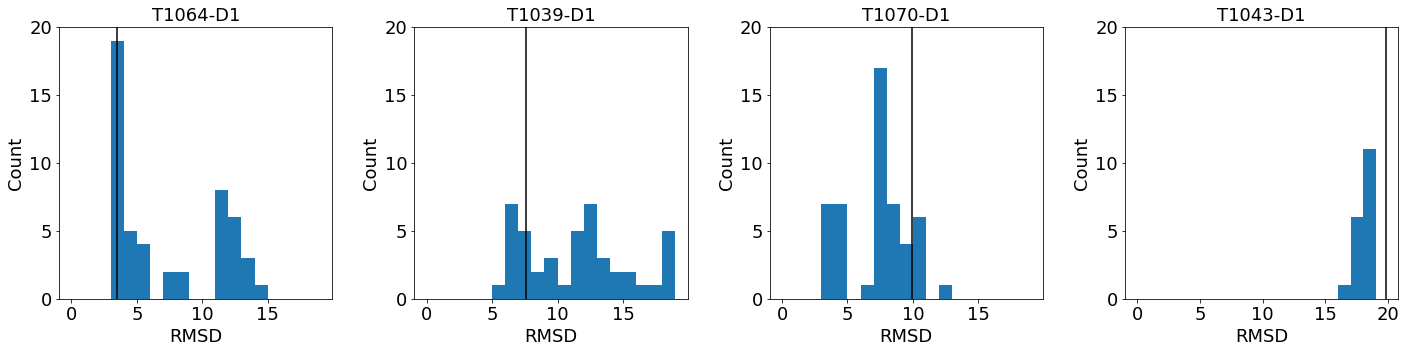

In [22]:
plt.rcParams.update({'font.size': 18})

#DOMS = ["T1070-D1","T1039-D1","T1038-D1","T1043-D1","T1064-D1"]
fig, ax = plt.subplots(1,4, figsize=(24,5))
fig.subplots_adjust(wspace=.3)
k = 0
for i in [4,1,0,3]:
    ax[k].hist([j[1] for j in mask_pairs[i]], bins = np.arange(0,20,1))
    ax[k].vlines(no_mask_pairs[i][1], 0 ,20, color = 'black')
    ax[k].set_ylim(0,20)
    ax[k].set_xlabel("RMSD")
    ax[k].set_ylabel("Count")
    ax[k].set_title(DOMS[i], fontsize = 18)
    k +=1 
plt.savefig(f"../figures/mask_sensitivity.svg", bbox_inches='tight')


# Remove individual sequences

In [15]:
md = model_d()

In [17]:
#data_to_plot = {}
for DOM in ["T1070-D1"]:
#for DOM in ["T1039-D1","T1064-D1","T1070-D1"]:
    prefix = f"../data_for_AF_figures/{DOM}_e_None_t_Gentle_Cool/"
    middle = ".None.random"
    outputs = pickle.load(open(prefix+DOM+middle+".out_dict.best", "rb"))
    opt_msa = outputs["msa"]
    INPUTS = prep_inputs(DOM)
    _, output_init_msa = drop_and_run_af(md, DOM)
    _, output_opt_msa = drop_and_run_af(md, DOM,  mod_msa = opt_msa)
    print(f"for MMSEQS MSA,  RMSD: {rmsd(INPUTS, output_init_msa):.2f}, PLDDT: {mean_plddt(output_init_msa):.2f}")
    print(f"for our MSA,  RMSD: {rmsd(INPUTS, output_opt_msa):.2f}, PLDDT: {mean_plddt(output_opt_msa):.2f}")
    drop_init = drop_each_seq(md, DOM)
    drop_opt = drop_each_seq(md, DOM, mod_msa = opt_msa)
    data_to_plot[DOM] = (eval_lists[DOM][1:], drop_init, drop_opt, INPUTS, output_opt_msa, output_init_msa)
#    pickle.dump(data_to_plot, open(f"data_to_plot_for_drop","wb"))

for MMSEQS MSA,  RMSD: 9.91, PLDDT: 0.64
for our MSA,  RMSD: 2.74, PLDDT: 0.91
removing seq 1
removing seq 2
removing seq 3
removing seq 4
removing seq 5
removing seq 6
removing seq 7
removing seq 8
removing seq 9
removing seq 10
removing seq 11
removing seq 12
removing seq 13
removing seq 14
removing seq 15
removing seq 16
removing seq 17
removing seq 18
removing seq 19
removing seq 20
removing seq 21
removing seq 22
removing seq 23
removing seq 24
removing seq 25
removing seq 26
removing seq 27
removing seq 28
removing seq 29
removing seq 30
removing seq 31
removing seq 32
removing seq 33
removing seq 34
removing seq 35
removing seq 36
removing seq 37
removing seq 38
removing seq 39
removing seq 40
removing seq 41
removing seq 42
removing seq 43
removing seq 44
removing seq 45
removing seq 46
removing seq 47
removing seq 48
removing seq 49
removing seq 50
removing seq 51
removing seq 52
removing seq 53
removing seq 54
removing seq 55
removing seq 56
removing seq 57
removing seq 58
re

In [37]:
data_to_plot = pickle.load( open(f"data_to_plot_for_drop","rb"))

In [18]:
thresh = {}
thresh["T1039-D1"] = 1e-15
thresh["T1064-D1"] = 1e-3
thresh["T1070-D1"] = 1e-3

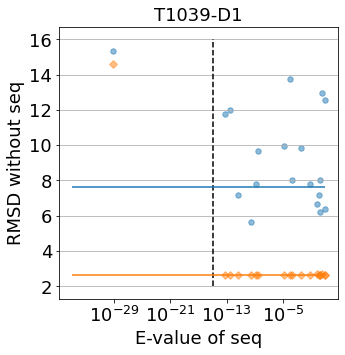

In [45]:
for n, DOM in enumerate(["T1039-D1"]):
    eval_lists[DOM][1:], drop_init, drop_opt, INPUTS, output_opt_msa, output_init_msa = data_to_plot[DOM]
    scatter_by_eval(eval_lists[DOM][1:], drop_init, drop_opt, INPUTS, output_opt_msa, output_init_msa, legend = (n==2), title = DOM, v = thresh[DOM], xrange= (1e-35, 10))


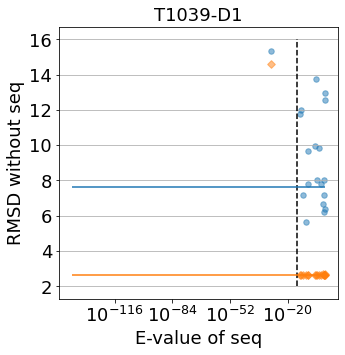

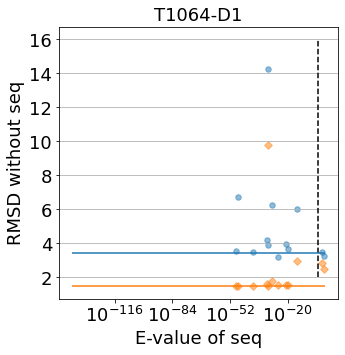

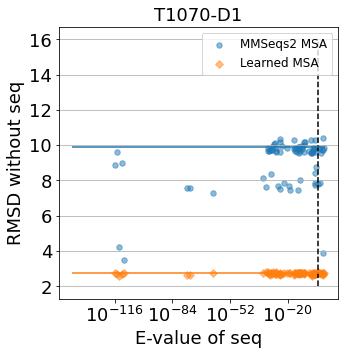

In [46]:
for n, DOM in enumerate(["T1039-D1","T1064-D1","T1070-D1"]):
    eval_lists[DOM][1:], drop_init, drop_opt, INPUTS, output_opt_msa, output_init_msa = data_to_plot[DOM]
    scatter_by_eval(eval_lists[DOM][1:], drop_init, drop_opt, INPUTS, output_opt_msa, output_init_msa, legend = (n==2), title = DOM, v = thresh[DOM])


# Remove distant sequences

In [16]:
def idx_below_thresh(t, evals):
    return [_ for _ in range(len(evals)) if evals[_]<t]

In [19]:
#sizes of MSAs
for DOM in ["T1039-D1","T1064-D1","T1070-D1"]:
    restrict_to = idx_below_thresh(thresh[DOM], eval_lists[DOM])
    print(len(eval_lists[DOM]), len(restrict_to))


20 2
14 12
81 73


In [20]:
for_df = []
for DOM in ["T1039-D1","T1064-D1","T1070-D1"]:
    prefix = f"../data_for_AF_figures/{DOM}_e_None_t_Gentle_Cool/"
    middle = ".None.random"
    outputs = pickle.load(open(prefix+DOM+middle+".out_dict.best", "rb"))
    opt_msa = outputs["msa"]
    INPUTS = prep_inputs(DOM)
    
    restrict_to = idx_below_thresh(thresh[DOM], eval_lists[DOM])
    
    # baseline MSAs
    _, output_init_msa = drop_and_run_af(md, DOM)
    _, output_opt_msa = drop_and_run_af(md, DOM,  mod_msa = opt_msa)
    
    
    #restricted MSAs
    rmsd_init_msa_r = restrict_and_print_error(md, DOM, [restrict_to] , mod_msa= None)
    rmsd_opt_msa_r = restrict_and_print_error(md, DOM, [restrict_to] , mod_msa= opt_msa)
    
    # just query seq
    rmsd_q = restrict_and_print_error(md, DOM, [[0]], mod_msa= None)
    for_df.append([DOM, rmsd(INPUTS, output_init_msa), rmsd(INPUTS, output_opt_msa), rmsd_init_msa_r, rmsd_opt_msa_r, rmsd_q])

df = pd.DataFrame(for_df, columns = ['Domain', 'MMSeq2 MSA','Learned MSA', 'Restricted MMSeq2 MSA','Restricted Learned MSA', "Query only"])
pickle.dump(df, open(f"rmsd_restricted_df","wb"))

for MMSEQS MSA

restrict to seqs: [0, 1], RMSD: 2.79, PLDDT: 0.74
for our MSA

restrict to seqs: [0, 1], RMSD: 2.91, PLDDT: 0.84
for MMSEQS MSA

restrict to seqs: [0], RMSD: 14.41, PLDDT: 0.45
for MMSEQS MSA

restrict to seqs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13], RMSD: 12.11, PLDDT: 0.41
for our MSA

restrict to seqs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13], RMSD: 2.48, PLDDT: 0.70
for MMSEQS MSA

restrict to seqs: [0], RMSD: 12.25, PLDDT: 0.34
for MMSEQS MSA

restrict to seqs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76], RMSD: 4.51, PLDDT: 0.68
for our MSA

restrict to seqs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 5

In [62]:
df = pickle.load(open(f"rmsd_restricted_df","rb"))

In [63]:
df = df.set_index("Domain")
df = df[['Query only', 'MMSeq2 MSA', 'Restricted MMSeq2 MSA','Learned MSA', 'Restricted Learned MSA']]

In [64]:
df = df.reindex(["T1064-D1","T1039-D1","T1070-D1"])
df

,Query only,MMSeq2 MSA,Restricted MMSeq2 MSA,Learned MSA,Restricted Learned MSA
Domain,,,,,
T1064-D1,12.249804,3.455900,12.111107,1.478327,2.483016
T1039-D1,14.414209,7.617135,2.787596,2.659266,2.912428
T1070-D1,11.556510,9.905559,4.511048,2.745706,2.705894


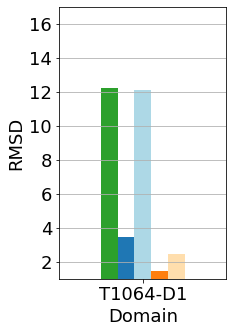

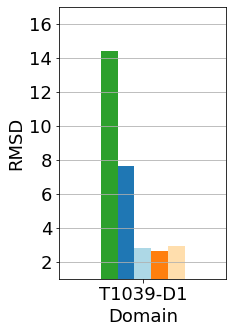

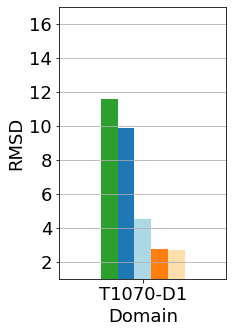

In [65]:
for DOM in ["T1064-D1","T1039-D1","T1070-D1"]:
    dfr =df.filter(items = [DOM], axis=0)
    plt.rcParams.update({'font.size': 18})
    ax = dfr.plot.bar(rot=0,figsize = (3,5),  color = ['tab:green', 'tab:blue', 'lightblue', 'tab:orange', 'navajowhite'])
    ax.set_ylabel("RMSD")
    ax.get_legend().remove()
    #ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    ax.grid(axis = 'y')
    ax.set_ylim(1,17)
    ax.set_yticks([2,4,6,8,10,12,14,16],[2,4,6,8,10,12,14,16]);
    plt.savefig(f"../figures/rmsd_compare_{DOM}.svg", bbox_inches='tight')

In [57]:
#T1064-D1 highest confidence prediction pLDDT, RMSD  (0.8761522, 1.5524526)
#T1039-D1 highest confidence prediction pLDDT, RMSD  (0.8998832, 3.2341647)
#T1070-D1 highest confidence prediction pLDDT, RMSD  (0.9123933, 1.9636279)

df['MSA Learned on restricted set'] = [1.5524526, 3.2341647, 1.9636279 ]

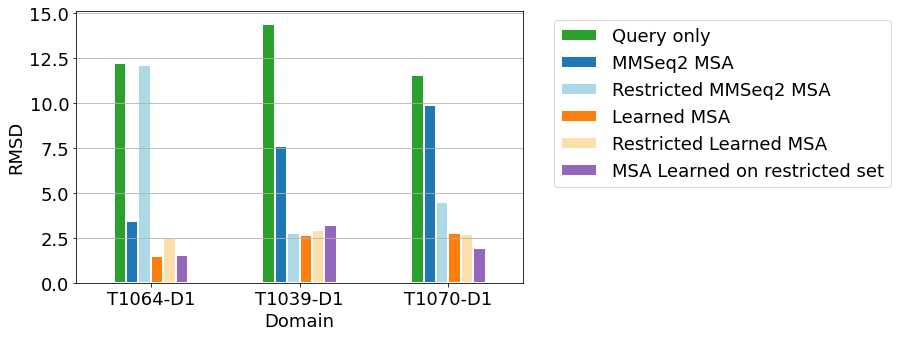

In [58]:
plt.rcParams.update({'font.size': 18})
ax = df.plot.bar(rot=0,figsize = (8,5), edgecolor='white', linewidth=2, color = ['tab:green','tab:blue', 'lightblue', 'tab:orange', 'navajowhite', 'tab:purple'])
ax.set_ylabel("RMSD")
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax.grid(axis = 'y')
plt.savefig(f"../figures/rmsd_compare.svg", bbox_inches='tight')
